# Information Retrieval and Web Analytics

#**Part1**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Load Python packages
Let's first import all the packages that you will need during this assignment.

In [ ]:
import nltk
nltk.download('stopwords')
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import string
import json
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### Load data into memory
The dataset is stored in the json file, and it contains 4,000 tweets related to Hurrican Ian. Each line readed represents a tweet, and for each tweet we have its corresponding information.

In [ ]:
docs_path = 'drive/Shareddrives/IR/Project/data/tw_hurricane_data.json'
with open(docs_path) as fp:
    lines = fp.readlines()

In [ ]:
print("Total number of tweets: {}".format(len(lines)))

Total number of tweets: 4000


First, we will implement the mandatory preprocessing in the function ```clean_tweet(line)```.

It will take as an input a line, and it will:

- Transform into lower case
- Remove punctiation marks
- Tokenize the text to get a list of terms (*split function*)
- Remove stop words
- Stem terms (example: to stem the term 'researcher', we will use ```stemming.stem(researcher)```)

The extra tasks such as removing emojis 

In [ ]:
def clean_tweet(line, emojis):
    """
    Preprocess the article text (title + body) removing stop words, stemming,
    transforming in lowercase and return the tokens of the text.
    
    Argument:
    line -- string (text) to be preprocessed
    
    Returns:
    line - a list of tokens corresponding to the input text after the preprocessing
    """

    line=str(line)  # by default everything assumed as string

    line = line.lower()  # transform into lower case

    line = re.sub(r'\\n', ' ', line)  #remove new lines

    line = line.translate(str.maketrans('', '', string.punctuation))  # remove punctuation marks

    line = re.sub(r'http\S+', '', line)  # remove links

    if emojis: # remove emojis
        ### https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
        remove_emojis = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               u"\u2026" # ...
                               u"\u2019" # '
                               u"\u2066"
                               u"\u2069"
                               u"\u231b"
                               "]+", flags=re.UNICODE)
        line = remove_emojis.sub(r'', str(line))

                     
    line = line.split()  # Tokenize the text to get a list of terms

    stop_words = set(stopwords.words("english")) # remove the stopwords
    line = [x for x in line if x not in stop_words]  

    stemmer = PorterStemmer() #stem terms
    line = [stemmer.stem(word) for word in line]    
        
    return line

In [ ]:
def process_json_line(json_line):   #given a json line iterates throuhg its content and creates another json with values formated

  new_dict = {}

  index_stored = 0
  for key, value in json_line.items():

    if (key=="full_text"): new_dict["Tweet"] = clean_tweet(value, True) #process tweet

    elif(key=="created_at"): new_dict["Date"] = clean_tweet(value, False) #process tweet date      

    elif(key=="retweet_count"): new_dict["Retweets"] = value #number of retweet, no need of processing

    elif(key=="favorite_count"): new_dict["Likes"] = value #number of likes, no need of processing
    elif(key=="id"): new_dict["Tweet_id"] = [str(value)] #store tweet id as str

    elif(key=="user"): new_dict["Username"] = clean_tweet(value["screen_name"], True) #process username

    elif(key=="entities"): #process hashtags
      hashtags=[]
      for i in range(len(value["hashtags"])):
        hashtags.append(clean_tweet(value["hashtags"][i]["text"], False))
      new_dict["Hashtags"] = hashtags

  new_dict["Url"] = 'https://twitter.com/'+ new_dict["Username"][0] + '/status/' + str(new_dict["Tweet_id"][0]) #generate url

      
  return new_dict

In [ ]:
json_processed=[]

for line in lines:

  data=json.loads(line)
  
  json_line=process_json_line(data) #format json

  json_processed.append(json_line) #store line

#### Mapping ids
Mapping tweets IDs with the document IDS.

In [ ]:
import csv
mapping_dict = {} # create empty dictionary to store the documents id

docs_path = 'drive/Shareddrives/IR/Project/data/tweet_document_ids_map.csv'
csv_file = csv.reader(open(docs_path, 'rU'), delimiter="\t", quotechar='|') # open csv

for line in csv_file: mapping_dict[line[1]] = line[0]   # store the indexes in the dictionary (tweet id, document id)

for j in json_processed:
  m = []
  m.append(str(mapping_dict[j['Tweet_id'][0]]))
  j['doc_id'] = m   # add the document id in the json dictionary

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: 'U' mode is deprecated
  """


In [ ]:
json_processed[39]

{'Date': ['fri', 'sep', '30', '183626', '0000', '2022'],
 'Tweet_id': ['1575917502554513408'],
 'Tweet': ['florida', 'love', 'publix', 'hurricaneian'],
 'Hashtags': [['florida'], ['hurricaneian']],
 'Username': ['momagainstmedia'],
 'Retweets': 0,
 'Likes': 0,
 'Url': 'https://twitter.com/momagainstmedia/status/1575917502554513408',
 'doc_id': ['doc_40']}

In [ ]:
print(json_processed[252])

{'Date': ['fri', 'sep', '30', '182614', '0000', '2022'], 'Tweet_id': ['1575914937880305664'], 'Tweet': ['new', 'lawmak', 'governor', 'around', 'countri', 'busi', 'week', 'particularli', 'deal', 'prepar', 'deal', 'hurricaneian', 'east', 'coast', 'latest', 'state', 'state'], 'Hashtags': [['new'], ['hurricaneian']], 'Username': ['dmgsllc'], 'Retweets': 1, 'Likes': 1, 'Url': 'https://twitter.com/dmgsllc/status/1575914937880305664', 'doc_id': ['doc_253']}


#**Part2**

###Indexing

####  Build inverted index

In [ ]:
inverted_index = defaultdict(list)

for j in json_processed:
  terms = j['Tweet']

  current_page_index = {}

  for position, term in enumerate(terms): #Loop over all terms
      try:
          # if the term is already in the index for the current page (current_page_index)
          # append the position to the corresponding list (elemento 1 del arreglo, el 0 es la id del documento)
          current_page_index[term][1].append(position)
      except:
          # Add the new term as dict key and initialize the array of positions and add the position
          current_page_index[term] = [j['doc_id'], array('I', [position])]  #'I' indicates unsigned int (int in Python)

  # merge the current page index with the main index
  for term_page, posting_page in current_page_index.items():
      inverted_index[term_page].append(posting_page)

In [ ]:
inverted_index = {key: value for key, value in sorted(inverted_index.items())}

In [ ]:
import math
tf_idf = {}

for i in mapping_dict.values():
  tf_idf[i] = [0.0] * len(inverted_index)  # initialize document vectors

for index, term in enumerate(inverted_index):
  df = len(inverted_index[term])  # document frequency of the term 
  for doc in inverted_index[term]:
    f = len(doc[1])  # term frequency of the term in the document doc

    #in this case we only compute weights for terms that appear, so the condition of below is not necessary
    #if f==0:
      #tf_idf[doc[0][0]][index] = 0

    w = (1 + math.log(f, 2)) * math.log(len(mapping_dict) / df, 2)
    tf_idf[doc[0][0]][index] = w

In [ ]:
queries = {}
queries["q1"] = clean_tweet("Last hurricane in Florida", True)
queries["q2"] = clean_tweet("Terrible hurricane north carolina", True)
queries["q3"] = clean_tweet("Medical assistance Florida", True)
queries["q4"] = clean_tweet("Last news report Ian", True)
queries["q5"] = clean_tweet("Dealing with east coast tragedy", True)

In [ ]:
import math
tf_idf_q = {}

for q in queries.keys():
  tf_idf_q[q] = [0.0] * len(inverted_index)  # initialize document vectors

for index, term in enumerate(inverted_index):
  df = len(inverted_index[term])  # document frequency of the term 
  for k, q in queries.items():
    f =q.count(term)  # term frequency of the term in the query q
    if(f==0):#if frequency is 0, weight is 0
      tf_idf_q[k][index] = 0
    else:
      w = (1 + math.log(f, 2)) * math.log(len(mapping_dict) / df, 2)
      tf_idf_q[k][index] = w


In [ ]:
from numpy.linalg import norm
cosine = {"q1":{},"q2":{},"q3":{},"q4":{},"q5":{}}

for q in tf_idf_q.keys():
  query = tf_idf_q[q]
  for d in tf_idf.keys():
    doc = tf_idf[d]
    cosine[q][d] = np.dot(query, doc) / (norm(query) * norm(doc))  # compute cosine similarity

In [ ]:
for q in queries:
  cosine[q] = dict(sorted(cosine[q].items(), key=lambda x: x[1], reverse=True))  # sort cosine similarity in descending order

In [ ]:
cosine.items()
k_ranking=[0]*5

i=0
for q in queries:
  k_ranking[i] = {k for k in list(cosine[q].keys())[:10]}  # get the top 10 documents for query q using cosine similarity
  print("Ranking for query",i+1,":", k_ranking[i])
  i=i+1


Ranking for query 1 : {'doc_3287', 'doc_1012', 'doc_1655', 'doc_3884', 'doc_2862', 'doc_2507', 'doc_640', 'doc_1305', 'doc_341', 'doc_1154'}
Ranking for query 2 : {'doc_2151', 'doc_2430', 'doc_241', 'doc_2607', 'doc_1110', 'doc_1889', 'doc_2657', 'doc_3894', 'doc_3962', 'doc_3418'}
Ranking for query 3 : {'doc_1412', 'doc_1331', 'doc_670', 'doc_1466', 'doc_3255', 'doc_1192', 'doc_1732', 'doc_3766', 'doc_828', 'doc_1273'}
Ranking for query 4 : {'doc_1923', 'doc_2083', 'doc_2901', 'doc_2507', 'doc_2283', 'doc_3057', 'doc_2368', 'doc_3209', 'doc_3150', 'doc_1104'}
Ranking for query 5 : {'doc_2565', 'doc_3961', 'doc_336', 'doc_2182', 'doc_2519', 'doc_3285', 'doc_1151', 'doc_219', 'doc_3466', 'doc_253'}


###Evaluation

a. Query 1: Landfall in South Carolina

b. Query 2:Help and recovery during the hurricane disaster

c. Query 3:Floodings in South Carolina

In [ ]:
import pandas as pd
df_=pd.read_csv('drive/Shareddrives/IR/Project/data/evaluation_gt.csv')

queries = {}
queries_info = [{},{},{}]

queries["q1"]=clean_tweet("Landfall in South Carolina", True) #q1
queries["q2"]=clean_tweet("Help and recovery during the hurricane disaster", True)
queries["q3"]=clean_tweet("Floodings in South Carolina", True)


#compute vector representation of the queries (as in the previous section)
tf_idf_q = {}
for q in queries.keys():
  tf_idf_q[q] = [0.0] * len(inverted_index)  # initialize document vectors

for index, term in enumerate(inverted_index):
  df = len(inverted_index[term])  # document frequency of the term 
  for k, q in queries.items():
    f =q.count(term)  # term frequency of the term in the query q
    if(f==0):#if frequency is 0, weight is 0
      tf_idf_q[k][index] = 0
    else:
      w = (1 + math.log(f, 2)) * math.log(len(mapping_dict) / df, 2)
      tf_idf_q[k][index] = w

cosine = {"q1":{},"q2":{},"q3":{}}

for i in range(len(queries)):
  queries_info[i]=df_.loc[df_["query_id"]==(i+1)] #info about q1
  queries_info[i]=queries_info[i].reset_index()
  docs_set=(queries_info[i]["doc"].tolist()) #documents that we have information about, the ones we will evaluate
  tf_idf_set={k: tf_idf[k] for k in docs_set} #tf_idf of the documents we can evaluate for that query

  query = tf_idf_q["q"+str(i+1)]
  #cosine similarity for q1 docs
  for d in tf_idf_set.keys():
      doc = tf_idf_set[d]
      cosine["q"+str(i+1)][d] = np.dot(query, doc) / (norm(query) * norm(doc))

In [ ]:
#rank and output top k documents
for q in queries:
  cosine[q] = dict(sorted(cosine[q].items(), key=lambda x: x[1], reverse=True))  # sort cosine similarity in descending order

k_ranking=[0]*3
i=0
for q in queries:
  k_ranking[i] = {k for k in list(cosine[q].keys())[:10]}  # get the top 10 documents for query q using cosine similarity
  print("Ranking for query",i+1,":", k_ranking[i])
  i=i+1

Ranking for query 1 : {'doc_18', 'doc_45', 'doc_52', 'doc_122', 'doc_12', 'doc_165', 'doc_82', 'doc_100', 'doc_9', 'doc_501'}
Ranking for query 2 : {'doc_175', 'doc_1233', 'doc_453', 'doc_158', 'doc_268', 'doc_321', 'doc_504', 'doc_303', 'doc_373', 'doc_402'}
Ranking for query 3 : {'doc_1195', 'doc_112', 'doc_148', 'doc_150', 'doc_66', 'doc_198', 'doc_125', 'doc_30', 'doc_370', 'doc_65'}


In [ ]:
#completing datasets with predicted values
for q in range(len(queries)):
  queries_info[q]["Predicted"]=0

  for i in range(len(queries_info[q])):
    if(queries_info[q].loc[i, "doc"] in k_ranking[q]):
        queries_info[q].loc[i, "Predicted"]=1

  df_mapping = pd.DataFrame({
      'ranking': list(k_ranking[q])
      })

  sort_mapping = df_mapping.reset_index().set_index('ranking')
  queries_info[q]['ranking'] = queries_info[q]['doc'].map(sort_mapping['index'])
  queries_info[q] = queries_info[q].sort_values('ranking')

###### Precision @ K (P@K)


In [ ]:
def precision_at_k(doc_score, y_score, k=10): #binary relevance, predicted relevance, k for a given query
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    precision @k : float

    """
    order = np.argsort(y_score)[::-1] #we get the ranking of the documents according to the predicted score/ use np.argsort and [::1] to obtain the list of indexes of the predicted score sorted in descending order.
    doc_score = np.take(doc_score, order[:k]) # align the binary relevance to the corresponding document / use the indexes of point 1 to sort the actual relevance label of the documents (hint: np.take).
    relevant = sum(doc_score == 1) #get number of relevant documents
    return float(relevant) / k #calculate precision at k, which is the number of relevant documents trieved at k

In [ ]:
k = 10

P1 = precision_at_k(queries_info[0]["label"], queries_info[0]["Predicted"], k)
print("==> Precision@{} of Q1: {}\n".format(k, P1))

P2 = precision_at_k(queries_info[1]["label"], queries_info[1]["Predicted"], k)
print("==> Precision@{} of Q2: {}\n".format(k, P2))

P3 = precision_at_k(queries_info[2]["label"], queries_info[2]["Predicted"], k)
print("==> Precision@{} of Q3: {}\n".format(k, P3))

==> Precision@10 of Q1: 1.0

==> Precision@10 of Q2: 0.9

==> Precision@10 of Q3: 0.8



###### Recall @ K (R@K)

In [ ]:
def recall_at_k(doc_score, y_score, k): #binary relevance, predicted relevance, k for a given query
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    precision @k : float

    """
    total_relevant = doc_score
    order = np.argsort(y_score)[::-1] #we get the ranking of the documents according to the predicted score/ use np.argsort and [::1] to obtain the list of indexes of the predicted score sorted in descending order.
    doc_score = np.take(doc_score, order[:k]) # align the binary relevance to the corresponding document / use the indexes of point 1 to sort the actual relevance label of the documents (hint: np.take).
    relevant = sum(doc_score == 1) #get number of relevant documents
    return float(relevant) / len(total_relevant) #calculate precision at k, which is the number of relevant documents trieved at k

In [ ]:
k = 10

R1 = recall_at_k(queries_info[0]["label"], queries_info[0]["Predicted"], k)
print("==> Recall@{} of Q1: {}\n".format(k, R1))

R2 = recall_at_k(queries_info[1]["label"], queries_info[1]["Predicted"], k)
print("==> Recall@{} of Q2: {}\n".format(k, R2))

R3 = recall_at_k(queries_info[2]["label"], queries_info[2]["Predicted"], k)
print("==> Recall@{} of Q3: {}\n".format(k, R3))

==> Recall@10 of Q1: 0.5

==> Recall@10 of Q2: 0.45

==> Recall@10 of Q3: 0.4



###### Average Precision@K - AP@K

In [ ]:
def avg_precision_at_k(doc_score, y_score, k=10): #binary relevance, predicted relevance, k for a given query
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    average precision @k : float
    """
    gtp = np.sum(doc_score == 1) #Total number of gt positives
    order = np.argsort(y_score)[::-1] #same as for precision
    doc_score = np.take(doc_score, order[:k]) #same as for precision
    ## if all documents are not relevant
    if gtp == 0:
        return 0
    n_relevant_at_i = 0
    prec_at_i = 0
    for i in range(len(doc_score)):
        if doc_score[i] == 1: #only add the P@k when the doc is relevant
            n_relevant_at_i += 1
            prec_at_i += n_relevant_at_i / (i + 1) #calculate P@K (#docs relevant at k/k)
    return prec_at_i / gtp #return ap

In [ ]:
q2_ap=avg_precision_at_k(queries_info[1]["Predicted"], queries_info[1]["label"], k)
print(q2_ap)

0.8521031746031745


In [ ]:
k = 10

q1_ap=avg_precision_at_k(queries_info[0]["Predicted"], queries_info[0]["label"], k)
print("==> Average Precision@{} of Q1: {}\n".format(k, q1_ap))

q2_ap=avg_precision_at_k(queries_info[1]["Predicted"], queries_info[1]["label"], k)
print("==> Average Precision@{} of Q2: {}\n".format(k, q2_ap))

q3_ap=avg_precision_at_k(queries_info[2]["Predicted"], queries_info[2]["label"], k)
print("==> Average Precision@{} of Q3: {}\n".format(k, q3_ap))

==> Average Precision@10 of Q1: 1.0

==> Average Precision@10 of Q2: 0.8521031746031745

==> Average Precision@10 of Q3: 0.8333333333333334



###### F1-Score

In [ ]:
print(P1, R1)
print(P2, R2)
print(P3, R3)

1.0 0.5
0.9 0.45
0.8 0.4


In [ ]:
print("==> F1-score@{} of Q1: {}\n".format(k, 2 * (P1*R1) / (P1 + R1) ))

print("==> F1-score@{} of Q2: {}\n".format(k, 2 * (P2*R2) / (P2 + R2) ))

print("==> F1-score@{} of Q3: {}\n".format(k, 2 * (P3*R3) / (P3 + R3) ))

==> F1-score@10 of Q1: 0.6666666666666666

==> F1-score@10 of Q2: 0.6

==> F1-score@10 of Q3: 0.5333333333333333



###### Mean Average Precision (MAP)

In [ ]:
def map_at_k(search_res, k=10): #receives all the search esults dataframe containing all the queries and the results and relevances
    """
    Parameters
    ----------
    search_res: search results dataset containing:
        query_id: query id.
        doc_id: document id.
        predicted_relevance: relevance predicted through LightGBM.
        doc_score: actual score of the document for the query (ground truth).

    Returns
    -------
    mean average precision @ k : float
    """
    avp = []
    for q in search_res:  # loop over all query ids
        curr_data = q  # select data for current query (get a slice of the dataframe keeping only the data related to the current query)
        avp.append(avg_precision_at_k(np.array(curr_data["label"]), 
                   np.array(curr_data["Predicted"]), k))  #append average precision for current query
    return np.sum(avp) / len(avp), avp  # return mean average precision

In [ ]:
k = 10
map_k, avp = map_at_k(queries_info, 10)
map_k

0.8597751322751322

In [ ]:
# print((q1_ap+q2_ap+q3_ap)/3)

###### Mean Reciprocal Rank (MRR)

In [ ]:
def rr_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    Reciprocal Rank for qurrent query
    """

    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order. As before
    doc_score = np.take(doc_score, order[
                             :k])  # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k. As before
    if np.sum(doc_score) == 0:  # if there are not relevant doument return 0
        return 0
    return 1 / (np.argmax(doc_score == 1) + 1)  # hint: to get the position of the first relevant document use "np.argmax" (+1 because the idex starts from 0)


In [ ]:
k = 10

for i in range(len(queries)):
  print("==> MRR of Q{}: {}\n".format(i, rr_at_k(queries_info[i]["Predicted"], queries_info[i]["label"], k)))


==> MRR of Q0: 1.0

==> MRR of Q1: 1.0

==> MRR of Q2: 1.0



###### Normalized Discounted Cumulative Gain (NDCG)


  
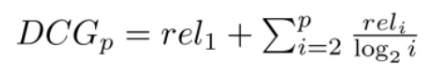

In [ ]:

def NDCG(query_ranking):
  NDCG = [0.0] * len(query_ranking)
  DCG = [0.0] * len(query_ranking)
  ideal_DCG = [0.0] * len(query_ranking)
  ideal = query_ranking.sort_values(by=['label'], ascending=False) # Sort to obtain the ideal order
  ideal = ideal.reset_index(drop=True) 
  query_ranking = query_ranking.reset_index(drop=True)

  for d in range(len(query_ranking)):
    
    if d == 0: # First 
      DCG[d] = query_ranking['label'][d]
      ideal_DCG[d] = ideal['label'][d]
    else:
      DCG[d] = DCG[d-1] + query_ranking['label'][d] / math.log( d + 1 ,2)
      ideal_DCG[d] = ideal_DCG[d-1] + ideal['label'][d] / math.log( d + 1 ,2)

    NDCG[d] = DCG[d] / ideal_DCG[d]
    

  return NDCG


In [ ]:
for i in range(len(queries)):
  print("NDCG of Q{}:".format(i+1), NDCG(queries_info[i]))


NDCG of Q1: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
NDCG of Q2: [1.0, 0.5, 0.6199062332840657, 0.6806060567602009, 0.7192278111338556, 0.7467366458934469, 0.7676939560659818, 0.7843898064324875, 0.798121093479434, 0.8096867362293507, 0.8646996067672038, 0.8646996067672038, 0.8646996067672038, 0.8646996067672038, 0.8646996067672038, 0.8646996067672038, 0.8646996067672038, 0.8646996067672038, 0.8646996067672038, 0.8646996067672038]
NDCG of Q3: [0.0, 0.5, 0.6199062332840657, 0.6806060567602009, 0.7192278111338556, 0.7467366458934469, 0.6849448736080526, 0.7075879058699875, 0.7262103760512999, 0.7418957838722607, 0.7969086544101138, 0.8499951968027791, 0.8499951968027791, 0.8499951968027791, 0.8499951968027791, 0.8499951968027791, 0.8499951968027791, 0.8499951968027791, 0.8499951968027791, 0.8499951968027791]


### Two-dimensional scatter representation

In [ ]:
import gensim
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
tweets = []
for j in json_processed: tweets.append(j['Tweet'])

model = gensim.models.Word2Vec(tweets)

X = model.wv[model.wv.vocab]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()